[![Segmentation](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/uscf_grinberg_neuro_images/tree/troy) ![Troy](https://github.com/ttompk/musings/blob/master/images/seg.png?raw=true)

# Image Preparation
---

This notebook is designed to processes labeled images for segmentation analysis.  

### Overview
#### Data types
There are two sources of data:
- images and image labels. Images are collected from the machine - the images you use to make predictions from. Labels have indexed pixels associated with specific regions of the image, i.e. objects of interest are labeled with specific pixels. These labeled images are often refered to as masks.  

### Operations
#### Images
Flow:  images --> images_grid --> images_beta  
1. Save raw images in a folder titled 'images'.
2. Reduce the raw image to a single layer. Backgroud: Tissue microarrays are collected using multiple channels. One channel will pertain to NueN staining. Open the file in GIMP and save the single NeuN layer as a separate .tif file in a directory labeled 'images_beta'.
3. In instances where a single image contains an assortment of other images, the single layer image should be stored in a folder titled 'images_grid'. These images are then combined with the corresponding labels and cropped to create separate images. Using GIMP: open image first then open the corresponding label as a new layer (using 'open as layer...'). Save the individual cropped images in 'images_beta'.

#### Labels
Flow:  labels --> labels_grid --> labels_beta --> labels_binary
1. Save orginal labeled images in a folder titled 'labels'.
2. 


In [40]:
from platform import python_version
import os
print("Written in python: 3.7.4")
print('Your python version: {}'.format(python_version()))
print('Development environment: {}'.format(os.environ['CONDA_DEFAULT_ENV']))
# this code prevents memory leakage
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

Written in python: 3.7.4
Your python version: 3.7.4
Development environment: fastai


In [25]:
# basic kit - included in default anaconda env list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
#import pandas_profiling
import re
import collections
import math

In [26]:
from fastai.vision import *
from PIL import Image as pil_image
from src.img_functions import *

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


There are 27 image files.
First 18 image files:
0:	Name: data/images_beta/TrainingData_1_original.tif
	Shape: torch.Size([3, 3032, 3012])

1:	Name: data/images_beta/TrainingData_3_original.tif
	Shape: torch.Size([3, 3012, 2500])

2:	Name: data/images_beta/TrainingData_4_original.tif
	Shape: torch.Size([3, 640, 918])

3:	Name: data/images_beta/TrainingData_8_original_1.tif
	Shape: torch.Size([3, 531, 568])

4:	Name: data/images_beta/TrainingData_8_original_10.tif
	Shape: torch.Size([3, 566, 560])

5:	Name: data/images_beta/TrainingData_8_original_11.tif
	Shape: torch.Size([3, 570, 564])

6:	Name: data/images_beta/TrainingData_8_original_12.tif
	Shape: torch.Size([3, 575, 565])

7:	Name: data/images_beta/TrainingData_8_original_2.tif
	Shape: torch.Size([3, 554, 559])

8:	Name: data/images_beta/TrainingData_8_original_3.tif
	Shape: torch.Size([3, 626, 626])

9:	Name: data/images_beta/TrainingData_8_original_4.tif
	Shape: torch.Size([3, 521, 562])

10:	Name: data/images_beta/TrainingData_8

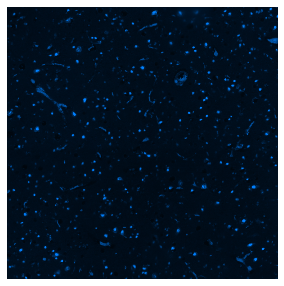

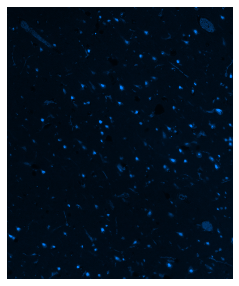

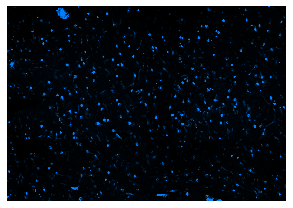

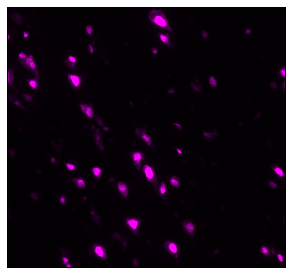

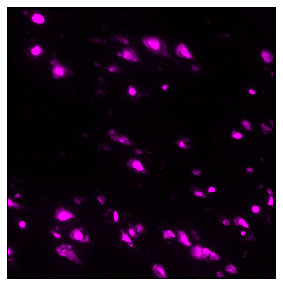

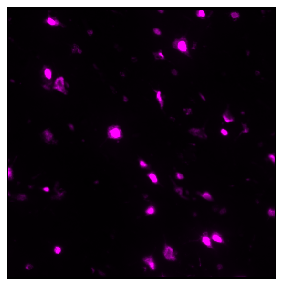

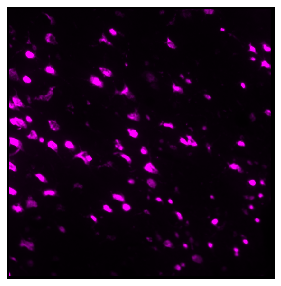

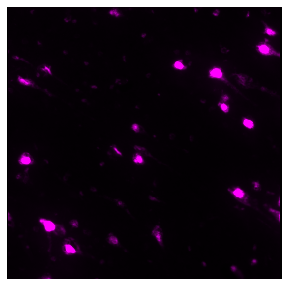

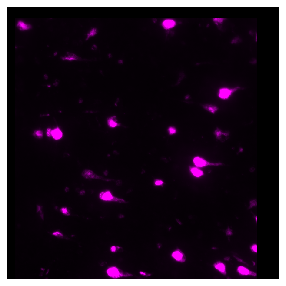

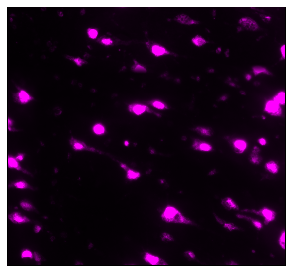

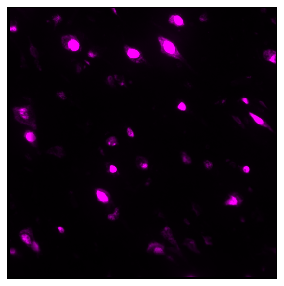

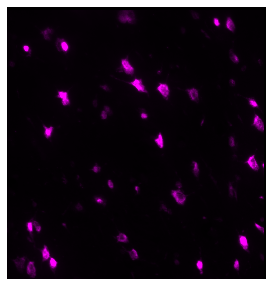

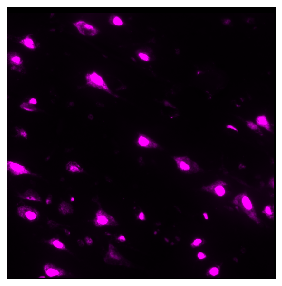

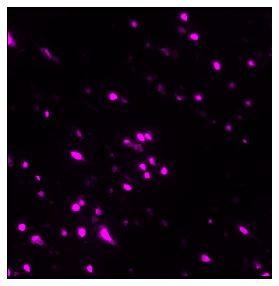

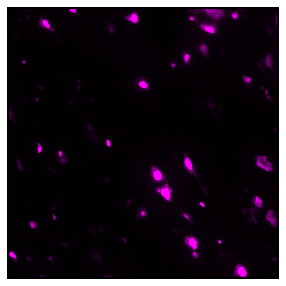

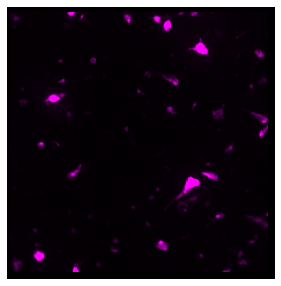

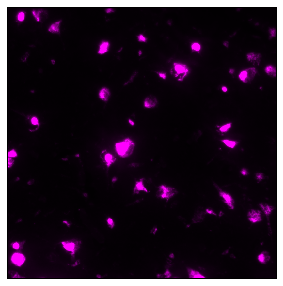

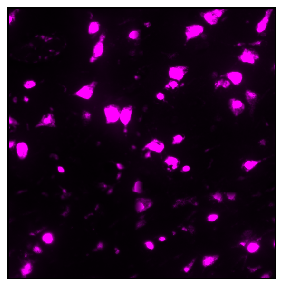

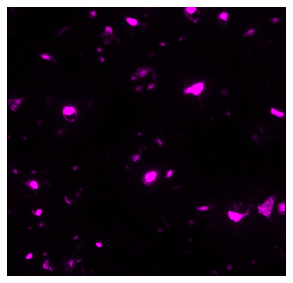

In [28]:
# image sources
#path_img = Path('data/images')   # raw images
path_img = Path('data/images_beta')   # images ready for cutting

# a list of image filenames (posixpath)
img_names = get_image_files(path_img) 

# Print out info on the training images.
train_img_test(img_names, open_image, n_display=5)

There are 27 image files.
First 5 image files:
---------------------
0
Name: data/images_beta/TrainingData_1_original.tif
Size: Train - [3032 3012] 	Mask - [3032 3016]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0]]])
---------------------
1
Name: data/images_beta/TrainingData_3_original.tif
Size: Train - [3012 2500] 	Mask - [3012 2500]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
---------------------
2
Name: data/images_beta/TrainingData_4_original.tif
Size: Train - [640 918] 	Mask - [640 918]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0

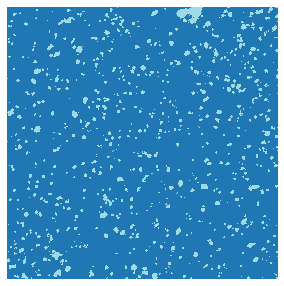

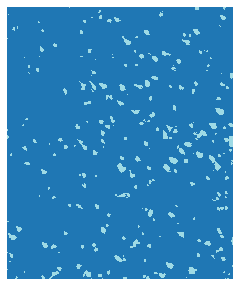

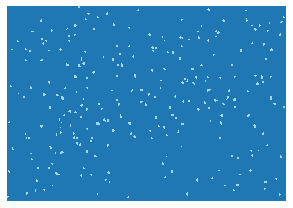

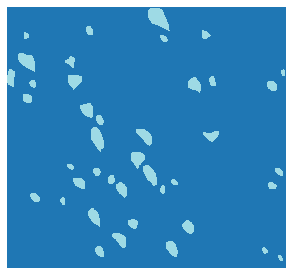

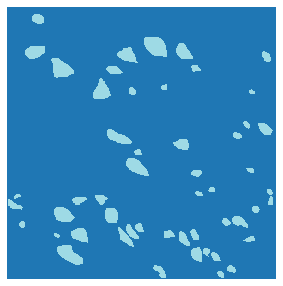

In [32]:
# matches the images with corresponding label images
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'    # only works with PosixPath object

# label image sources
#path_lbl = Path('data/labels', )   # raw label images go here
#path_lbl = Path('data/labels_beta', )   # label images before binary conversion
path_lbl = Path('data/labels_binary', )   # label images set to binary - ready for cutting

# run the binary function
lbl_names = get_image_files(path_lbl)   # a list of posixpath filenames
label_info(img_names, lbl_names, get_y_fn, n_display=5)   # overview of training images and masks

In [14]:
# if the pixel values are greater than 1 then set pixel value to 1
def bw_0_1(path_lbl, save_dir):
    ''' converts image to binary, set any value greater than 0 to 1
    input: 
        path_lbl:     posixpath. directory of label files to be converted
        save_dir:     str. directory to save new label files
    output:
        saves converted file to save_dir
    return:  None
    '''
    print("Converting files from {}".format(path_lbl))
    for image_file in get_image_files(path_lbl):
        print(image_file)
        img = pil_image.open(image_file)
        
        # convert to black and white
        if img.mode != 'L':
            img = img.convert(mode='L') # 'L' = 8-bit pixels, black and white  # '1' = 1 bit pixels
        
        # change pixel values to 1 for any value greater than 0
        data = np.array(img)
        print("pre-change: {}".format(np.unique(data)))
        data[data>0]=1
        print("post-change: {}".format(np.unique(data)))
        print(img.mode)
        
        # create a new image and save
        img = pil_image.fromarray(data)
        img.save(save_dir+'/'+image_file.name)

In [33]:
# convert labels to binary
save_dir = 'data/labels_binary'
# path_lbl should be a directory with 2 color labels
bw_0_1(path_lbl, save_dir)

data/labels_binary/TrainingData_1_original_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_3_original_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_4_original_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_10_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_11_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_12_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_1_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_2_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_3_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_4_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_binary/TrainingData_8_original_5_P.tif
pre-change: [0 1]
post-change: [0 1]
L
data/labels_b

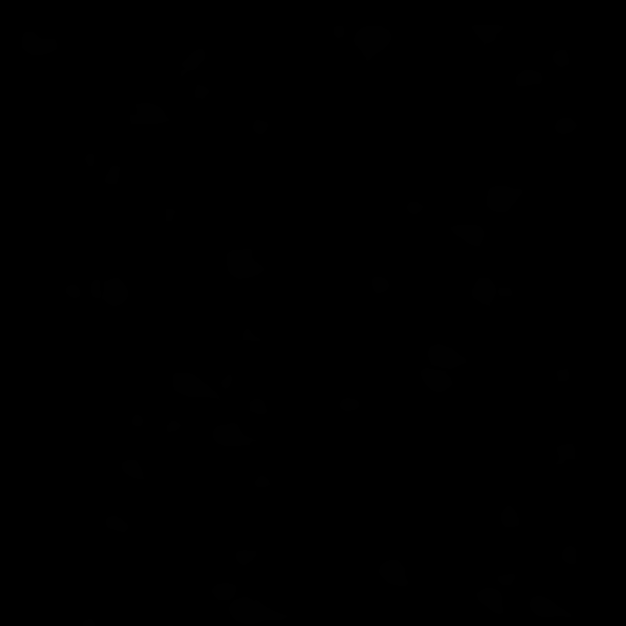

In [36]:
path_lbl_binary = Path('data/labels_binary', )
img_file = get_image_files(path_lbl_binary)[8]
img = pil_image.open(img_file)
display(img)

In [17]:
img.mode

'L'

In [18]:
data = np.array(img)
np.unique(data)

array([0, 1], dtype=uint8)

In [19]:
img.getcolors()

[(324077, 0), (8827, 1)]

In [20]:
h = img.height
w = img.width
print(w,h)

572 582


In [23]:
# slice the images
size = 250
save_dir = 'data/images_sliced_'+str(size)+'/'
img_slicer(size, save_dir, path_img)

In [37]:
# slice the labels
size = 250
save_dir = 'data/labels_sliced_'+str(size)+'/'
img_slicer(size, save_dir, path_lbl_binary)